In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm import tqdm
import random
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
from preprocessing import *

In [3]:
from mimic_diagnoses import *

In [8]:
patients = pd.read_csv('mimic_data/PATIENTS.csv')
admissions = pd.read_csv('mimic_data/ADMISSIONS.csv')
diagnoses = pd.read_csv('mimic_data/DIAGNOSES_ICD.csv')
admissions_leadii, patients_leadii, diagnoses_leadii = mimic_diagnoses.get_leadii_dataframes(patients, admissions, diagnoses)
mimic_diagnoses.add_icd_10_code_to_diagnoses(diagnoses_leadii)
data = get_aligned_ss_and_bp(admissions_leadii)

/Users/luismendoza/Desktop/CS/HMC CS/Clinic/EIT-Clinic-Waveform/sleep/risk_classification/mimic_diagnoses.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnoses['ICD10_CODE'] = diagnoses.ICD9_CODE.apply(lambda x: icd_9_to_10_from_code(x, icd_9_to_10_d))


In [9]:
print(diagnoses_leadii.columns)

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE',
       'ICD10_CODE'],
      dtype='object')


In [91]:
class_threshold = 0.5

In [33]:
patient_ids = [tup[0] for tup in list(data.keys())]
start_before_sleep_arrays = [get_start_before_sleep(bp_ss) for bp_ss in list(data.values())]

print("starting features")


/Users/luismendoza/Desktop/CS/HMC CS/Clinic/EIT-Clinic-Waveform/sleep/risk_classification/preprocessing.py:209: RuntimeWarning: invalid value encountered in scalar divide
  if np.sum(ss[sleep_start:end] == 3) / len(ss[sleep_start:end]) >= 0.5:


starting features


TypeError: 'tuple' object does not support item assignment

In [60]:
features = get_time_series_features(patient_ids, start_before_sleep_arrays, True, 8, 8, diagnoses_leadii)


In [61]:
labels = features[1]
data_list = list(features[0])

data_length = len(data_list)
train_size = int(data_length * 0.8)
val_size = data_length - train_size

print(len(labels))
print(len(data_list))
ones = sum(labels)
print(ones)

for i in range(len(labels)):
    data_list[i] = [labels[i], data_list[i]]

random.shuffle(data_list)

train_list = data_list[:train_size]
val_list = data_list[train_size:]

90
90
43


In [213]:
def preprocess_dataset(dataset, normalize_sleep=True):
    """
    Converts dataset into CNN-ready tensors by padding/truncating time series.

    Args:
        dataset: list of [label, np.array([bp, ss])]
        normalize_sleep: whether to normalize sleep stages
        target_length: fixed sequence length

    Returns:
        X_tensor: torch.FloatTensor (batch, 2, target_length)
        y_tensor: torch.FloatTensor (batch,)
    """
    X_series = []
    Y = []

    for label, data in dataset:
        dis = data[0]
        sys = data[1]
        
        dis = (dis - dis.mean()) / dis.std()
        sys = (sys - sys.mean()) / sys.std()
        print(f"dis:{dis}")
        print(f"sys: {sys}")


        

        signal = np.stack([dis, sys])
        X_series.append(signal)
        Y.append(label)
    
    np.array(X_series)

    X_tensor = torch.tensor(X_series, dtype=torch.float32)
    y_tensor = torch.tensor(np.array(Y), dtype=torch.float32)

    return X_tensor, y_tensor


In [214]:
X_train, y_train = preprocess_dataset(train_list)
X_val, y_val = preprocess_dataset(val_list)

dis:[-1.09286980e+00 -9.77715345e-01 -8.53295593e-01 -1.03330715e+00
 -9.02269325e-01 -9.80362574e-01 -9.39330528e-01 -1.00286402e+00
 -1.08625173e+00 -9.34036071e-01 -1.16434497e+00 -7.18286925e-01
 -6.65342349e-01 -5.70042113e-01 -5.55482355e-01 -4.95919707e-01
 -5.72689342e-01 -5.50187897e-01 -5.51511511e-01 -6.42840904e-01
 -5.59453198e-01 -5.09155851e-01 -5.25039224e-01 -2.81494176e-01
 -5.25088859e-02 -1.86193939e-01 -2.62963574e-01 -1.49132736e-01
 -2.07371770e-01 -1.78252253e-01 -3.55616582e-01 -3.45027666e-01
 -3.13260921e-01 -4.37680674e-01 -5.01214165e-01 -8.54619207e-01
 -2.39138515e-01 -2.89435862e-01 -3.23849836e-01 -3.88706941e-01
 -4.45622360e-01 -5.21068380e-01 -4.37680674e-01 -4.50916818e-01
 -4.32386216e-01 -3.10613692e-01 -3.19878993e-01 -3.52969353e-01
 -4.74741877e-01 -4.00619471e-01 -1.09424305e-01 -1.04129847e-01
 -8.06969089e-01 -7.87114873e-01 -8.55942821e-01 -7.83144030e-01
 -8.87709567e-01 -8.87709567e-01 -7.39464755e-01 -3.22526222e-01
 -2.07371770e-01 -5.5

dis:[ 1.20725743  0.45960561  0.56641301  0.88683522  0.78002781  0.56641301
  1.20725743  0.56641301  0.88683522  0.88683522  1.42087223  1.20725743
  0.99364262  0.99364262  0.99364262  1.63448704  0.78002781  0.67322041
  0.1391834   0.3527982   0.78002781  0.03237599  0.78002781  1.42087223
  1.20725743 -0.07443141  0.78002781  0.56641301  0.45960561  0.99364262
  0.56641301  1.20725743  0.56641301  0.99364262  0.99364262  0.99364262
  0.78002781  1.20725743  1.52767964  1.20725743  0.99364262  0.3527982
  1.20725743  1.20725743  1.42087223  0.99364262  0.56641301  0.99364262
  0.78002781  0.67322041  1.10045002  0.78002781  0.88683522  0.78002781
  1.42087223  1.20725743  0.56641301  0.99364262  0.99364262  1.20725743
  0.56641301  1.20725743  1.63448704  0.88683522  1.20725743  0.78002781
  0.88683522  0.99364262  0.78002781  0.78002781  1.31406483  0.56641301
  0.78002781  0.78002781  1.20725743  0.99364262  1.31406483  0.45960561
  0.99364262  0.99364262  1.10045002  0.99364262

dis:[ 2.24048946e-03 -6.01035651e-02  2.24048946e-03  2.24048946e-03
  1.26928599e-01  1.26928599e-01 -6.01035651e-02  1.26928599e-01
  2.51616708e-01  1.89272653e-01 -6.01035651e-02 -9.12755924e-02
  1.26928599e-01  1.26928599e-01  1.26928599e-01  4.07476844e-01
  2.82788735e-01  1.26928599e-01  6.45845440e-02  1.89272653e-01
  1.58100626e-01  1.26928599e-01  3.34125167e-02  1.89272653e-01
  1.26928599e-01 -2.89315378e-02  2.51616708e-01  1.58100626e-01
  2.51616708e-01  3.13960762e-01  2.51616708e-01  6.45845440e-02
 -6.01035651e-02 -1.22447620e-01 -1.84791674e-01 -1.84791674e-01
 -1.22447620e-01 -1.22447620e-01 -2.47135729e-01 -2.47135729e-01
 -2.47135729e-01 -2.47135729e-01 -1.22447620e-01 -1.84791674e-01
 -1.22447620e-01 -1.22447620e-01  2.24048946e-03  6.45845440e-02
  6.45845440e-02  2.24048946e-03  2.24048946e-03  6.45845440e-02
  2.24048946e-03  1.26928599e-01  1.26928599e-01  1.26928599e-01
  6.45845440e-02  2.24048946e-03  1.26928599e-01  6.45845440e-02
  6.45845440e-02  1.2

dis:[ 0.83179281  0.61141994  0.75833518  0.90525043  0.68487756  0.97870806
  1.27253855  1.52964023  1.71328429  1.78674191  1.93365716  2.22748765
  1.93365716  2.15403003  1.78674191  0.68487756  0.39104707  0.64814875
  0.83179281  0.86852162  1.05216568  1.19908093  1.60309785  1.63982667
  1.63982667  1.93365716  1.86019954  1.93365716  1.93365716  1.7500131
  0.75833518  0.90525043  1.19908093  0.83179281  0.24413182 -0.38025798
 -0.7475461  -1.0781054  -1.3719359  -1.44539352 -1.29847827 -1.29847827
 -0.60063085 -0.27007154  0.39104707  0.39104707  0.46450469  0.68487756
  0.90525043  1.05216568  0.97870806  0.90525043  1.27253855  1.16235211
  1.05216568  0.61141994  0.68487756  0.75833518  0.75833518  0.75833518
  0.83179281  0.5012335   0.68487756  0.90525043  0.90525043  0.90525043
  0.72160637  0.83179281  0.68487756  0.61141994  0.68487756  0.61141994
  0.42777588  0.53796231  0.5012335   0.35431826  0.31758944  0.61141994
  0.46450469  0.39104707  0.46450469  0.35431826

dis:[-0.83736149 -0.76566767 -0.37135162 -0.3355047  -0.47889236 -0.3355047
 -0.19211705 -0.69397384 -0.83736149 -0.98074915 -1.05244297 -0.47889236
 -0.40719853 -0.69397384 -0.87320841 -0.90905532 -0.90905532 -0.69397384
 -0.69397384 -0.40719853 -0.47889236 -0.76566767 -0.69397384 -0.47889236
 -0.90905532 -0.22796396 -0.55058618 -0.26381088 -0.3355047  -0.69397384
 -0.29965779 -0.12042322 -0.08457631 -0.40719853 -0.47889236  0.16635208
 -0.19211705 -0.0487294  -0.26381088 -0.15627014 -0.40719853 -0.40719853
 -0.37135162 -0.40719853 -0.12042322 -0.0487294  -0.3355047   0.202199
  0.23804591  0.45312739  0.41728048  0.56066813  0.52482122  0.66820887
  0.7399027   0.38143356  0.38143356  0.30973974  0.23804591  0.45312739
  0.81159652  0.77574961  0.88329035  0.66820887  0.59651504  0.45312739
  0.30973974  0.52482122  0.45312739  0.38143356  0.38143356  0.38143356
  0.52482122 -0.0487294   0.30973974  0.7399027   0.88329035  0.7399027
  0.38143356  0.81159652  0.59651504  0.88329035  0

In [215]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.classes = ['Low Risk', 'High Risk']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label


In [216]:
train_data = CustomDataset(X_train, y_train)
val_data = CustomDataset(X_val, y_val)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)


Using 'cpu' device.


In [297]:
class CNN(nn.Module):
    def __init__(self, in_channels=2):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
        
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.classifier(x).squeeze(1)
        return x

In [306]:
def train_one_epoch(mb, loader, device, model, criterion, optimizer):

    model.train()

    losses = []

    num_batches = len(loader)
    dataiterator = iter(loader)

    for batch in progress_bar(range(num_batches), parent=mb):

        mb.child.comment = "Training"

        X, Y = next(dataiterator)
        X, Y = X.to(device), Y.to(device)

        output = model(X)

        loss = criterion(output, Y)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses

In [307]:
def validate(mb, loader, device, model, criterion):

    model.eval()

    losses = []
    num_correct = 0

    num_classes = len(loader.dataset.classes)
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    N = len(loader.dataset)
    num_batches = len(loader)
    dataiterator = iter(loader)

    with torch.no_grad():

        batches = range(num_batches)
        batches = progress_bar(batches, parent=mb) if mb else batches
        for batch in batches:

            if mb:
                mb.child.comment = f"Validation"

            X, Y = next(dataiterator)
            X, Y = X.to(device), Y.to(device)

            output = model(X)

            loss = criterion(output, Y)
            losses.append(loss.item())
            for i in range(len(output)):
                print(f'label: {Y[i]}, output: {output[i]}')

            predictions = (output > class_threshold).float()  
            comparisons = predictions == Y
            num_correct += comparisons.type(torch.float).sum().item()

            for result, clss in zip(comparisons, Y):
                clss = int(clss.item())  
                class_correct[clss] += result.item()
                class_total[clss] += 1

    accuracy = ((predictions == Y).sum().item() / len(Y))*100

    accuracies = {
        clss: 100 * class_correct[clss] / class_total[clss]
        for clss in range(num_classes)
    }

    return losses, accuracy, accuracies

In [308]:
def update_plots(mb, train_losses, valid_losses, epoch, num_epochs):

    # Update plot data
    max_loss = max(max(train_losses), max(valid_losses))
    min_loss = min(min(train_losses), min(valid_losses))

    x_margin = 0.2
    x_bounds = [0 - x_margin, num_epochs + x_margin]

    y_margin = 0.1
    y_bounds = [min_loss - y_margin, max_loss + y_margin]

    train_xaxis = torch.linspace(0, epoch + 1, len(train_losses))
    valid_xaxis = torch.linspace(0, epoch + 1, len(valid_losses))
    graph_data = [[train_xaxis, train_losses], [valid_xaxis, valid_losses]]

    mb.update_graph(graph_data, x_bounds, y_bounds)

In [318]:
model = CNN().to(device)

summary(model, input_size=(2,960))

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
  
criterion = nn.BCEWithLogitsLoss()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 960]             352
       BatchNorm1d-2              [-1, 32, 960]              64
              ReLU-3              [-1, 32, 960]               0
            Conv1d-4              [-1, 64, 960]          10,304
       BatchNorm1d-5              [-1, 64, 960]             128
              ReLU-6              [-1, 64, 960]               0
         MaxPool1d-7              [-1, 64, 480]               0
            Conv1d-8             [-1, 128, 480]          41,088
       BatchNorm1d-9             [-1, 128, 480]             256
             ReLU-10             [-1, 128, 480]               0
        MaxPool1d-11             [-1, 128, 240]               0
           Conv1d-12             [-1, 256, 240]         164,096
      BatchNorm1d-13             [-1, 256, 240]             512
             ReLU-14             [-1, 2

label: 1.0, output: 0.49084150791168213
label: 0.0, output: 0.49040156602859497
label: 0.0, output: 0.4903368353843689
label: 0.0, output: 0.4904484748840332
label: 0.0, output: 0.4903446137905121
label: 0.0, output: 0.49033254384994507
label: 1.0, output: 0.49066126346588135
label: 0.0, output: 0.4907175302505493
label: 1.0, output: 0.49064600467681885
label: 0.0, output: 0.4909326732158661
label: 1.0, output: 0.4903150498867035
label: 0.0, output: 0.49048912525177
label: 1.0, output: 0.4903203248977661
label: 0.0, output: 0.4904659688472748
label: 0.0, output: 0.49041080474853516
label: 1.0, output: 0.4903455376625061
label: 1.0, output: 0.49035781621932983
label: 0.0, output: 0.4904080331325531


label: 1.0, output: 0.5436399579048157
label: 0.0, output: 0.5288417935371399
label: 0.0, output: 0.5258558988571167
label: 0.0, output: 0.5391163229942322
label: 0.0, output: 0.5255141854286194
label: 0.0, output: 0.5301568508148193
label: 1.0, output: 0.5322844982147217
label: 0.0, output: 0.5387262105941772
label: 1.0, output: 0.5509958267211914
label: 0.0, output: 0.5444583892822266
label: 1.0, output: 0.5265294313430786
label: 0.0, output: 0.5296286940574646
label: 1.0, output: 0.5318824648857117
label: 0.0, output: 0.5243568420410156
label: 0.0, output: 0.5286076664924622
label: 1.0, output: 0.5431894659996033
label: 1.0, output: 0.5332328081130981
label: 0.0, output: 0.5278251767158508


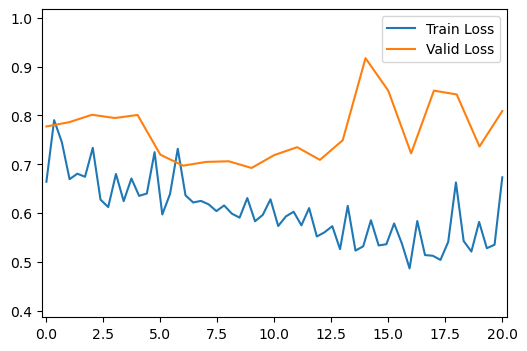

label: 1.0, output: 0.6501089930534363
label: 0.0, output: 0.5881033539772034
label: 0.0, output: 0.5689791440963745
label: 0.0, output: 0.6281174421310425
label: 0.0, output: 0.5687488913536072
label: 0.0, output: 0.5975896716117859
label: 1.0, output: 0.5939816236495972
label: 0.0, output: 0.6210227012634277
label: 1.0, output: 0.6638891696929932
label: 0.0, output: 0.6568058729171753
label: 1.0, output: 0.590822696685791
label: 0.0, output: 0.5960027575492859
label: 1.0, output: 0.5941624045372009
label: 0.0, output: 0.5623258948326111
label: 0.0, output: 0.6055409908294678
label: 1.0, output: 0.6565638780593872
label: 1.0, output: 0.5884963274002075
label: 0.0, output: 0.6007655262947083
label: 1.0, output: 0.7242307066917419
label: 0.0, output: 0.5798560976982117
label: 0.0, output: 0.5246706008911133
label: 0.0, output: 0.6714029312133789
label: 0.0, output: 0.49857500195503235
label: 0.0, output: 0.5900866985321045
label: 1.0, output: 0.5495548248291016
label: 0.0, output: 0.636

label: 1.0, output: 0.9973812699317932
label: 0.0, output: 0.9920308589935303
label: 0.0, output: 0.9857651591300964
label: 0.0, output: 0.9969547986984253
label: 0.0, output: 0.9088006615638733
label: 0.0, output: 0.9546578526496887
label: 1.0, output: 0.9111410975456238
label: 0.0, output: 0.9977987408638
label: 1.0, output: 0.9988791346549988
label: 0.0, output: 0.9991432428359985
label: 1.0, output: 0.8277540802955627
label: 0.0, output: 0.9960696697235107
label: 1.0, output: 0.9970493316650391
label: 0.0, output: 0.928290843963623
label: 0.0, output: 0.9864916205406189
label: 1.0, output: 0.9823862314224243
label: 1.0, output: 0.9977618455886841
label: 0.0, output: 0.9619767069816589
label: 1.0, output: 0.9957206845283508
label: 0.0, output: 0.9055171608924866
label: 0.0, output: 0.6519613265991211
label: 0.0, output: 0.9734992384910583
label: 0.0, output: 0.361727237701416
label: 0.0, output: 0.5656029582023621
label: 1.0, output: 0.4227699339389801
label: 0.0, output: 0.98684316

In [319]:
num_epochs = 20

train_losses = []
valid_losses = []
accuracies = []

mb = master_bar(range(num_epochs))
mb.names = ["Train Loss", "Valid Loss"]
mb.main_bar.comment = f"Epochs"

vl, accuracy, _ = validate(None, val_loader, device, model, criterion)
valid_losses.extend(vl)
accuracies.append(accuracy)

for epoch in mb:

    tl = train_one_epoch(mb, train_loader, device, model, criterion, optimizer)
    train_losses.extend(tl)

    vl, accuracy, acc_by_class = validate(mb, val_loader, device, model, criterion)
    valid_losses.extend(vl)
    accuracies.append(accuracy)

    update_plots(mb, train_losses, valid_losses, epoch, num_epochs)

Accuracy per class
     Low Risk: 36.4%
    High Risk: 71.4%
Highest Accuracy: 72.2%
Final Accuracy: 50.0%


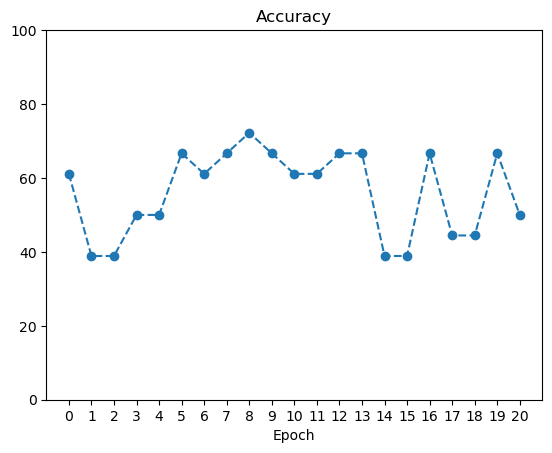

In [320]:
plt.plot(accuracies, '--o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.xticks(range(num_epochs+1))
plt.ylim([0, 100])

class_names = train_loader.dataset.classes
max_name_len = max(len(name) for name in class_names)

print("Accuracy per class")
for clss in acc_by_class:
    class_name = class_names[clss]
    class_accuracy = acc_by_class[clss]
    print(f"  {class_name:>{max_name_len+2}}: {class_accuracy:.1f}%")
print(f"Highest Accuracy: {max(accuracies):.1f}%")
print(f"Final Accuracy: {accuracies[-1]:.1f}%")

In [321]:
y_trues = []
y_preds = []
model.to(device)
for x, y in val_loader:
    y_trues.append(y.cpu())
    y_preds.append((model(x.to(device)) > class_threshold).cpu())


y_true = torch.hstack(y_trues)
y_pred = torch.hstack(y_preds)

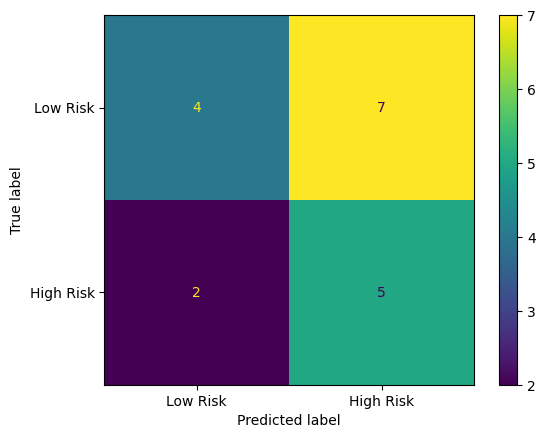

In [322]:
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot();